In [7]:
# init deterministic seed
seed = 863522
assert type(seed) is int, "Exclude letters, leave only numbers"

In [9]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina' # high-resolution plots

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# url to dataset
url = 'https://raw.githubusercontent.com/dsfb2/dsfb2-2024/main/assignment_3/data/tripadvisor_hotel_reviews.csv'

# fix seed
np.random.seed(seed)

The numeric rating for the review range from 1 to 5. However, many programming languages use zero-based indexing. Also, many machine learning algorithms and libraries assume the class labels are integers starting from 0.  Therefore, 1 will be substrcted from all ratings to convert the range from 1-5 to 0-4.

In [13]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(url)

# Inspect the first few rows of the dataset
print(df.head(), "\n")

# Check for null values and data types
print(df.info(), "\n")

# Check the unique values in the "Rating" column
print(df["Rating"].value_counts(), "\n")


X = df["Review"]
y = df["Rating"] = df["Rating"] - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB
None 

Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64 



In [5]:
# model building
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', max_df=0.8, min_df=5)
model = make_pipeline(vectorizer, MultinomialNB())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [11]:
# model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.5150036594291291

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.20      0.33       270
           1       0.23      0.04      0.07       360
           2       0.00      0.00      0.00       461
           3       0.34      0.32      0.33      1214
           4       0.59      0.92      0.72      1794

    accuracy                           0.52      4099
   macro avg       0.40      0.30      0.29      4099
weighted avg       0.43      0.52      0.44      4099


 Confusion Matrix:
[[  55   45    0  119   51]
 [   6   15    2  232  105]
 [   1    3    0  279  178]
 [   1    1    0  391  821]
 [   1    0    0  143 1650]]


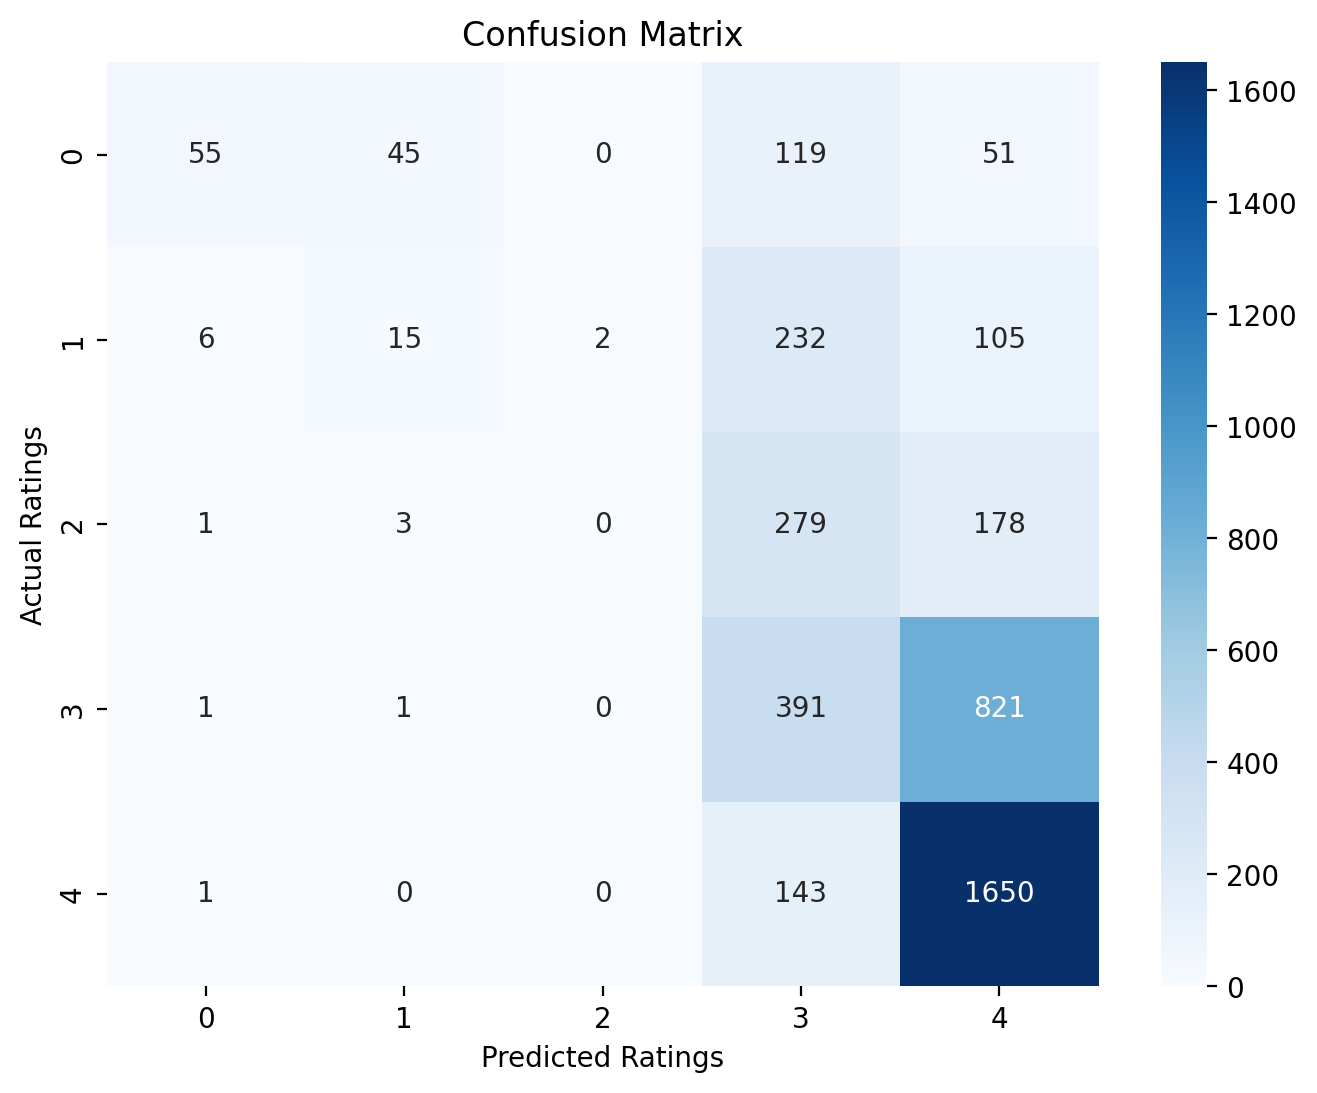

In [12]:
# visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(5), yticklabels=np.arange(5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

The Naive Bayes classifier achieved an overall accuracy of 43.91%, indicating that the model is heavily biased towards the majority class.

For ratings 0, 1, and 2, the precision, recall, and F1-scores are all 0, which means the model failed to predict these classes entirely. Besides, the extremely low recall for rating 3 and precision of 0.45 and a recall of 1.00 for rating 4, and as well as the confusion matrix, all demonstrate the model's poor performance and is almost exclusively predicting class 4.

Performance is not improved after some fine tuning of model parameters( such as max_features, stop_words, max_df, min_df)

This is likely due to the imbalanced dataset with 44.18% data belonging to class 4, and as well as the limitations of Naive Bayes in handling imbalanced data and its assumption of feature indepence, which makes it not suitable for complex text data.

To improve the results, balancing the dataset and switch to more advanced models such as logistic regression or transformer-based architectures(e.g., BERT) could better capture the patterns.

In [13]:
# install the library that contains checkpoints of models and tokenizers
!pip install transformers

In [ ]:
from transformers import BertTokenizerFast

MAX_LEN = 512                 # max length of sequence. we will use all 512 as our text articles are long.
TRAIN_BATCH_SIZE =4       # how many sequences are included in the training batch
VALID_BATCH_SIZE = 4       # how many sequences are included in the validation batch
EPOCHS = 3                 # how many epochs we will use during the training process
LEARNING_RATE =  1e-05         # our learning rate
TOKENIZER = BertTokenizerFast.from_pretrained('bert-base-uncased', lower=True) # our tokenizer

In [18]:
import torch

class TravelDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        # Tokenize the entire dataset at once for consistency
        tokenized_texts = TOKENIZER(
            df['Review'].values.tolist(),
            padding='max_length',
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        
        # Store tokenized data and labels
        self.input_ids = tokenized_texts['input_ids']
        self.attention_mask = tokenized_texts['attention_mask']
        self.labels = torch.tensor(df['Rating'].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    # def get_batch_labels(self, idx):
    #     # Fetch a single label as numpy array
    #     return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch input_ids and attention_mask for the given index
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx]
        }

    def __getitem__(self, idx):
        # Combine tokenized texts and labels
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.labels[idx]
        return batch_texts, batch_y


In [19]:
df = df.sample(frac=1, random_state=seed) # dataframe shuffle
split_index = int(0.8 * len(df))  # calculate the split index

# Method 1 - split is suitable for multi-splits: 
# train, val, test = np.split(df, [train_index, val_index])
# df_train, df_val = np.split(df, [split_index])

# Method 2: slicing:
df_train = df[:split_index]
df_val = df[split_index:]

print(f'Training set length is {len(df_train)} and validation set length {len(df_val)}')

Training set length is 16392 and validation set length 4099


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [20]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.3):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased') # pre-trained transformer
        self.dropout = nn.Dropout(dropout)                         # pool with dropout
        
        # fixed pre-trained model hidden layers 768
        # reviews 0 - 5, so 5 classes    
        self.linear = nn.Linear(768, 5)
            
        self.relu = nn.ReLU()                                      # ReLU activation function

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [21]:
import sys
import os
import getpass

# before we define our training loop, we create the folder, where we will save our model checkpoints
# check if running on Google Colab
if 'google.colab' in str(get_ipython()):

    print('Running on Colab')

    # import the Google Colab GDrive connector
    from google.colab import drive

    # mount GDrive inside the Colab notebook
    drive.mount('/content/drive')

    # name Colab Notebooks directory
    CHECKPOINT_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/dsfb2/a3'

else:
    # check if running on MacOS
    if sys.platform == 'darwin':
        print('Running on MacOS')

        # get the username
        user_name = getpass.getuser()

        # name main directory
        CHECKPOINT_DIRECTORY = f"/Users/{user_name}/dsfb2/a3"

    # check if running on Windows
    elif sys.platform == 'win32':
        print('Running on Windows')

        # get the username
        user_name = getpass.getuser()

        # name main directory
        CHECKPOINT_DIRECTORY = f"C:/Users/{user_name}/dsfb2/a3"

# create the main directory
if not os.path.exists(CHECKPOINT_DIRECTORY): os.makedirs(CHECKPOINT_DIRECTORY)


Running on Colab
Mounted at /content/drive


In [22]:
from torch.optim import Adam
from tqdm import tqdm
import os

# function for training and validation
def train_validate(model, df_train, df_val, learning_rate, epochs):

    # create tokenized datasets for training and validation
    train, val = TravelDataset(df_train), TravelDataset(df_val) # YOUR CODE HERE

    # create loaders for tensors
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=VALID_BATCH_SIZE)

    # activate GPU computing
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu').type
    print('[LOG] notebook with {} computation enabled'.format(str(device)))

    # initialize loss function
    criterion = nn.CrossEntropyLoss()# YOUR CODE HERE

    # initialize optimizer
    optimizer = Adam(model.parameters(), lr=learning_rate) # YOUR CODE HERE

    # send model and loss function to computational device
    model = model.to(device)# YOUR CODE HERE
    criterion = criterion.to(device)# YOUR CODE HERE

    # initialize empty lists for storing data
    history_val_loss=[]     # average training loss for epoch
    history_train_loss = [] # average validation loss for epoch
    history_val_acc=[]      # training accuracy for epoch
    history_train_acc = []  # validation accuracy for epoch

    # training and validation cycle
    for epoch in range(epochs):

        # set the model to the training mode (gradients are updated)
        # YOUR CODE HERE
        model.train()

        # initialize list for storing loss for each propagation
        loss_train = []

        # initilize lists for storing actual and predicted labels
        train_label_list = []
        train_output_list = []

################## TRAINING ##################

        # get our train input and label tensors for loader, tdqm is just a nice progress bar
        for train_input, train_label in tqdm(train_dataloader):

            # send training label, attention mask and id to device
            train_label =  train_label.to(device)# YOUR CODE HERE
            mask = train_input['attention_mask'].to(device)# YOUR CODE HERE
            input_id = train_input['input_ids'].to(device)# YOUR CODE HERE

            # receive predicted label
            output = model(input_id, mask)# YOUR CODE HERE

            # calculate the loss value between actual and predicted label
            batch_loss = criterion(output, train_label)# YOUR CODE HERE

            # store the loss
            loss_train.append(batch_loss.item())

            # save actual and predicted values
            train_label_list.extend(train_label.cpu().detach().numpy().tolist())
            train_output_list.extend(torch.sigmoid(output).cpu().detach().numpy().tolist())

            # reset graph gradients
            # YOUR CODE HERE
            optimizer.zero_grad()

            # backpropagate loss
            # YOUR CODE HERE
            batch_loss.backward()

            # update weights
            # YOUR CODE HERE
            optimizer.step()


        # calculate average training loss
        total_loss_train = np.mean(loss_train)
        # append average training loss
        history_train_loss.append(total_loss_train)
        # calculate training accuracy
        acc_train = accuracy_score(np.array(train_label_list).astype(int), np.argmax(np.array(train_output_list), axis=1))
        # append training accuracy
        history_train_acc.append(acc_train)

################## VALIDATION ##################

        # initialize list for storing loss for each propagation
        loss_val = []

        # initialize lists for storing actual and predicted labels
        val_label_list = []
        val_output_list = []

        # set the model to the validation mode (gradients are not updated)
        model.eval()

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                # send validation label, attention mask and id to device
                val_label = val_label.to(device) # YOUR CODE HERE
                mask =  val_input['attention_mask'].to(device) # YOUR CODE HERE
                input_id = val_input['input_ids'].to(device) # YOUR CODE HERE

                # receive predicted label
                output =  model(input_id, mask) # YOUR CODE HERE

                # calculate the loss value between actual and predicted label
                batch_loss = criterion(output, val_label) # YOUR CODE HERE

                # store the loss
                loss_val.append(batch_loss.item())

                # save actual and predicted values
                val_label_list.extend(val_label.cpu().detach().numpy().tolist())
                val_output_list.extend(torch.sigmoid(output).cpu().detach().numpy().tolist())

        # calculate average validation loss
        total_loss_val = np.mean(loss_val)
        # append average validation loss
        history_val_loss.append(total_loss_val)
        # calculate validation accuracy
        acc_val = accuracy_score(np.array(val_label_list).astype(int), np.argmax(np.array(val_output_list), axis=1))
        # append validation accuracy
        history_val_acc.append(acc_val)

        print(f'Epochs: {epoch} | Train Loss: {total_loss_train: .3f} | Train Accuracy: {acc_train: .3f} | Val Loss: {total_loss_val: .3f} | Val Accuracy: {acc_val: .3f}')
        model_name = f'{epoch}_tripadvisor_classifier.pth'
        model_path = os.path.join(CHECKPOINT_DIRECTORY, model_name)
        torch.save(model.state_dict(), model_path)

    return history_train_loss, history_val_loss, history_train_acc, history_val_acc


In [23]:
# initialize our model
model = BertClassifier()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Before training the model, move the code to Azure Labs

In [24]:
# check that gpu is activated

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu').type

if device == 'cuda':
    !nvidia-smi
elif device == 'mps':
    print('Using Apple M-series SoC GPU accelerator')
else:
    print('Using CPU')

Mon Nov 25 03:09:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [25]:
# train the model
# YOUR CODE HERE
history_train_loss, history_val_loss, history_train_acc, history_val_acc = train_validate(model, df_train, df_val, LEARNING_RATE, EPOCHS)

[LOG] notebook with cuda computation enabled


100%|██████████| 4098/4098 [25:47<00:00,  2.65it/s]


Epochs: 0 | Train Loss:  0.909 | Train Accuracy:  0.610 | Val Loss:  0.737 | Val Accuracy:  0.687


100%|██████████| 4098/4098 [25:50<00:00,  2.64it/s]


Epochs: 1 | Train Loss:  0.695 | Train Accuracy:  0.699 | Val Loss:  0.734 | Val Accuracy:  0.689


100%|██████████| 4098/4098 [25:49<00:00,  2.65it/s]


Epochs: 2 | Train Loss:  0.556 | Train Accuracy:  0.771 | Val Loss:  0.770 | Val Accuracy:  0.678


100%|██████████| 4098/4098 [25:49<00:00,  2.65it/s]


Epochs: 3 | Train Loss:  0.407 | Train Accuracy:  0.843 | Val Loss:  0.917 | Val Accuracy:  0.652


100%|██████████| 4098/4098 [25:49<00:00,  2.65it/s]


Epochs: 4 | Train Loss:  0.282 | Train Accuracy:  0.893 | Val Loss:  1.132 | Val Accuracy:  0.650


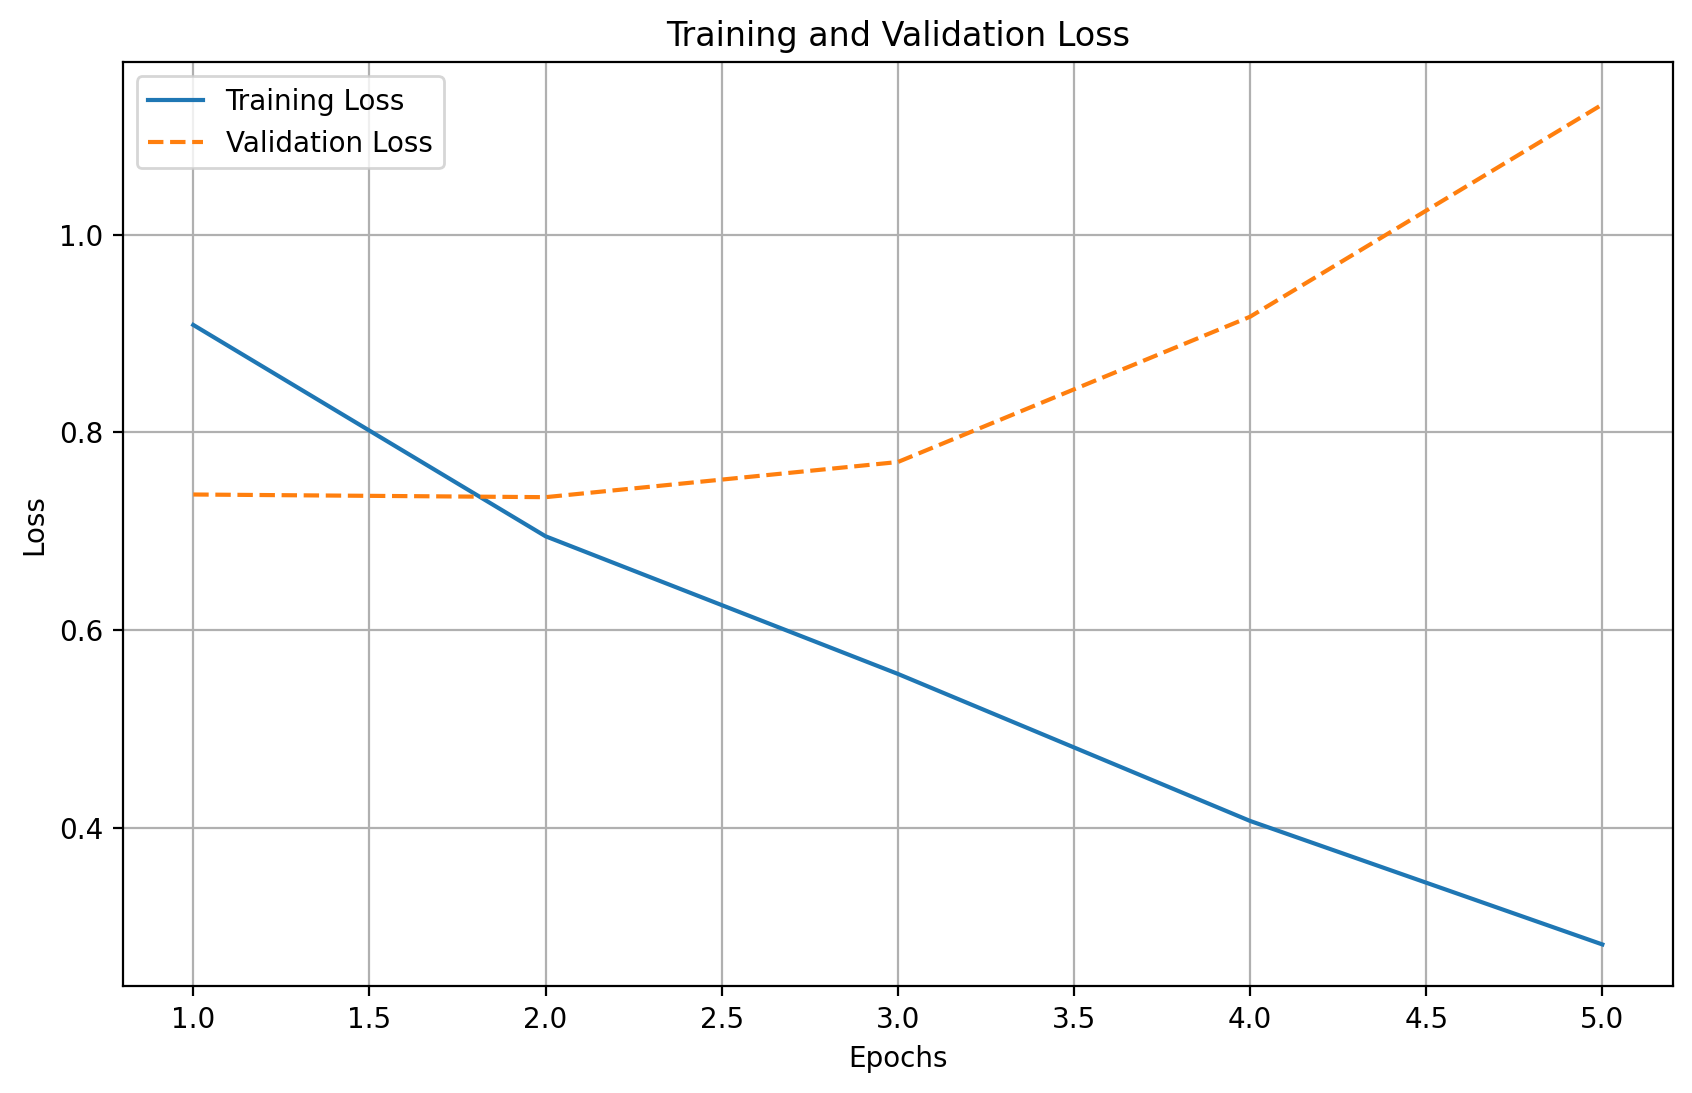

In [33]:
# ploting the loss
import matplotlib.pyplot as plt

def plot_loss(history_train_loss, history_val_loss):
    """
    Plots training and validation loss over epochs.

    Parameters:
    - history_train_loss: List of training loss values over epochs.
    - history_val_loss: List of validation loss values over epochs.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(np.array(range(1, len(history_train_loss) +1 )), history_train_loss, label='Training Loss')
    plt.plot(np.array(range(1, len(history_val_loss) +1 )),history_val_loss, label='Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function after training
plot_loss(history_train_loss, history_val_loss)


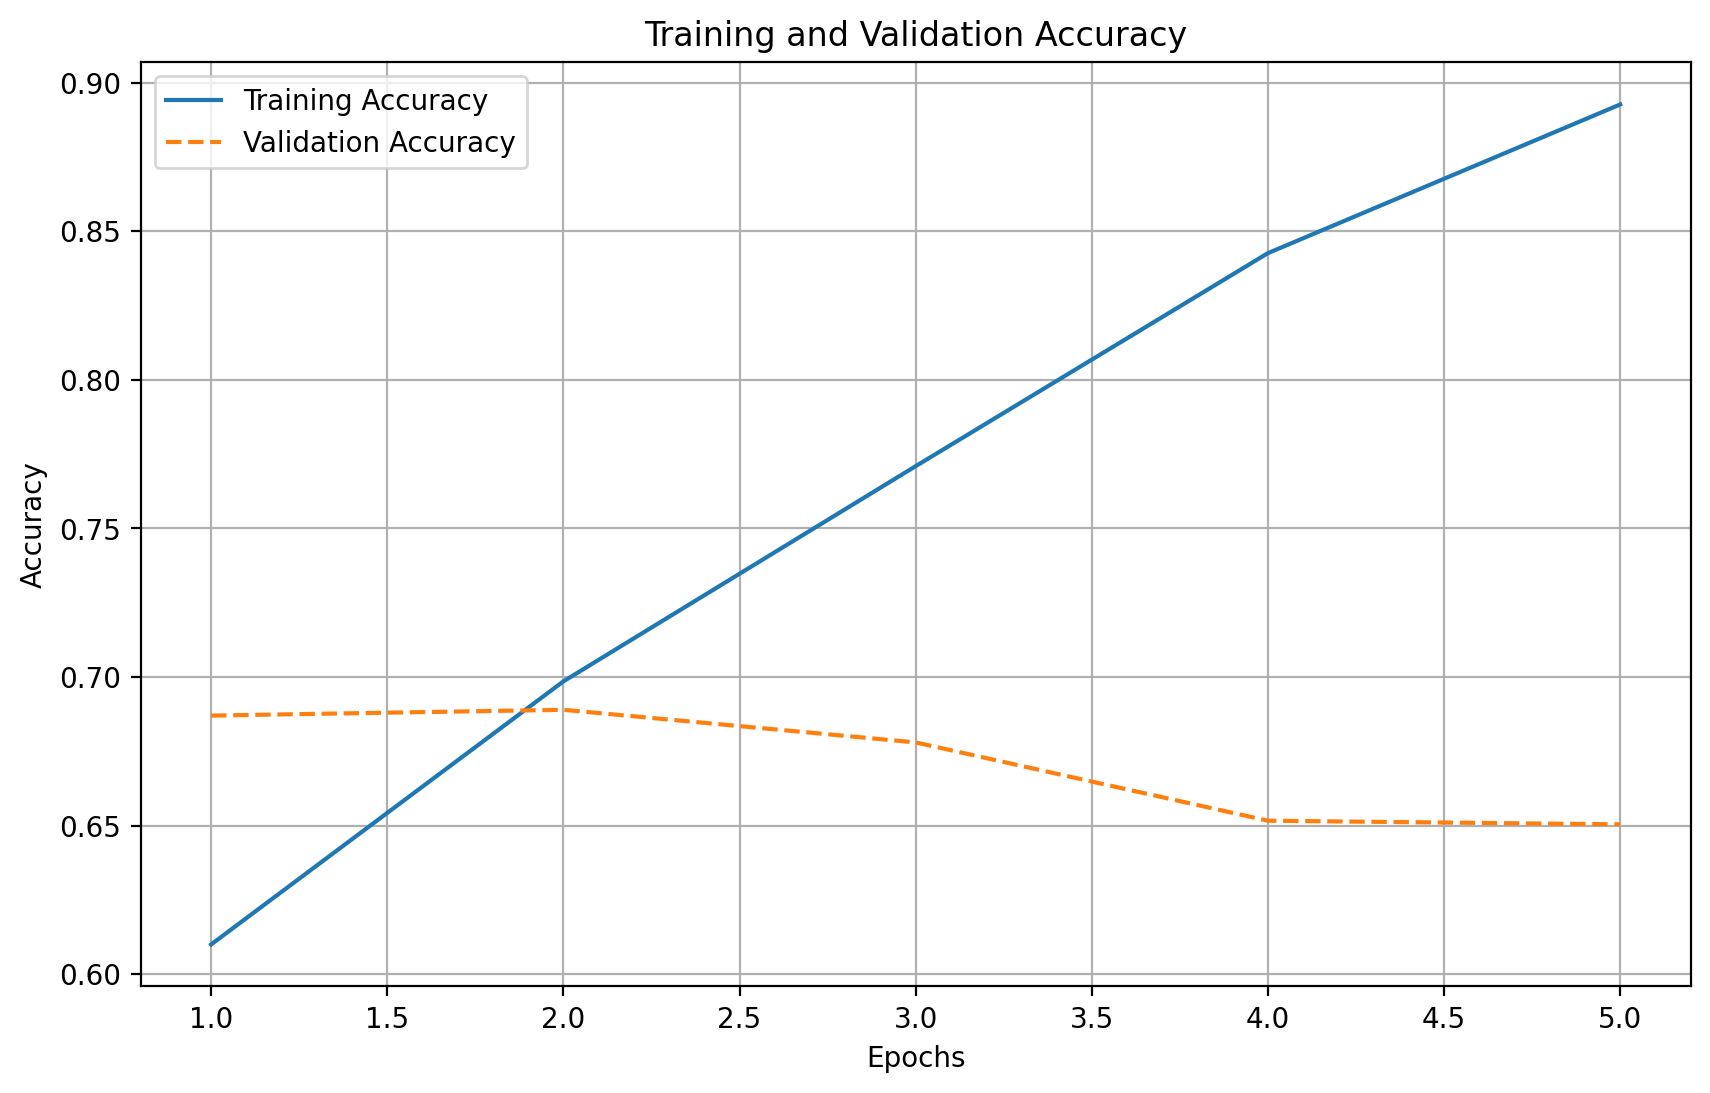

In [35]:
# plotting the accuracy
# YOUR CODE HERE
def plot_accuracy(history_train_acc, history_val_acc):
    """
    Plots training and validation accuracy over epochs.

    Parameters:
    - history_train_acc: List of training accuracy values over epochs.
    - history_val_acc: List of validation accuracy values over epochs.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(np.array(range(1, len(history_train_loss) +1 )), history_train_acc, label='Training Accuracy')
    plt.plot(np.array(range(1, len(history_val_loss) +1 )), history_val_acc, label='Validation Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function after training
plot_accuracy(history_train_acc, history_val_acc)

In [41]:
# load saved state
# YOUR CODE HERE

def load_model(model_class, checkpoint_directory, model_filename, device):
    """
    Load a saved model state in Google Colab or other environments.

    Parameters:
    - model_class: The class of the model (e.g., BertClassifier).
    - checkpoint_directory: Directory where the model checkpoint is stored.
    - model_filename: The name of the saved model file (e.g., 'best_model.pth').
    - device: The device to load the model on ('cpu', 'cuda', etc.).

    Returns:
    - model: The model with the loaded state.
    """
    # Construct the full path to the model file
    model_path = os.path.join(checkpoint_directory, model_filename)

    # Check if the model file exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model checkpoint not found at {model_path}")

    # Initialize the model
    model = model_class()

    # Load the saved model state dictionary
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Move the model to the specified device
    model = model.to(device)

    print(f"[LOG] Model loaded from {model_path}")
    return model


# Specify the model filename
MODEL_FILENAME = '2_tripadvisor_classifier.pth'

# Specify the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
loaded_model = load_model(BertClassifier, CHECKPOINT_DIRECTORY, MODEL_FILENAME, device)


<ipython-input-41-2a82cc45e180>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


[LOG] Model loaded from /content/drive/MyDrive/Colab Notebooks/dsfb2/a3/2_tripadvisor_classifier.pth


In [42]:
# evaluate model
# YOUR CODE HERE

def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluates the model on a given dataset.

    Args:
        model: The model to evaluate.
        dataloader: DataLoader for the dataset.
        criterion: Loss function.
        device: Device to use (e.g., 'cuda', 'cpu').

    Returns:
        Tuple: (average loss, actual labels, predicted labels)
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculation
        for batch_input, batch_labels in dataloader:
            batch_labels = batch_labels.to(device)
            mask = batch_input['attention_mask'].to(device)
            input_ids = batch_input['input_ids'].to(device)

            outputs = model(input_ids, mask)
            loss = criterion(outputs, batch_labels)
            total_loss += loss.item()

            all_labels.extend(batch_labels.cpu().detach().numpy().tolist())
            all_predictions.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(np.array(all_labels).astype(int), np.argmax(np.array(all_predictions), axis=1))
    print(f'Accuracy: {accuracy: .3f}')

    return avg_loss, np.array(all_labels).astype(int), np.argmax(np.array(all_predictions), axis=1)



In [43]:
df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=seed)  # Split validation into validation and test
test_data = TravelDataset(df_test)  # Create test dataset
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=VALID_BATCH_SIZE)
criterion = torch.nn.CrossEntropyLoss().to(device)

# Evaluate on test data
_, actual_labels, predicted_labels = evaluate_model(loaded_model, test_dataloader, criterion, device)



Accuracy:  0.648


In [44]:
# create classification report
# YOUR CODE HERE
from sklearn.metrics import classification_report

target_names = ['Rating 1', 'Rating 2', 'Rating 3', 'Rating 4', 'Rating 5']  # Replace with your class names

# Generate and print the classification report
print("Classification Report:")
print(classification_report(actual_labels, predicted_labels, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

    Rating 1       0.75      0.50      0.60         6
    Rating 2       0.56      0.45      0.50        11
    Rating 3       0.45      0.62      0.53         8
    Rating 4       0.50      0.46      0.48        37
    Rating 5       0.76      0.80      0.78        66

    accuracy                           0.65       128
   macro avg       0.60      0.57      0.58       128
weighted avg       0.65      0.65      0.64       128



[[11  4  1  0  0]
 [ 5 14 10  0  1]
 [ 0  3 16  4  0]
 [ 0  1 11 44 16]
 [ 0  1  4 24 86]]


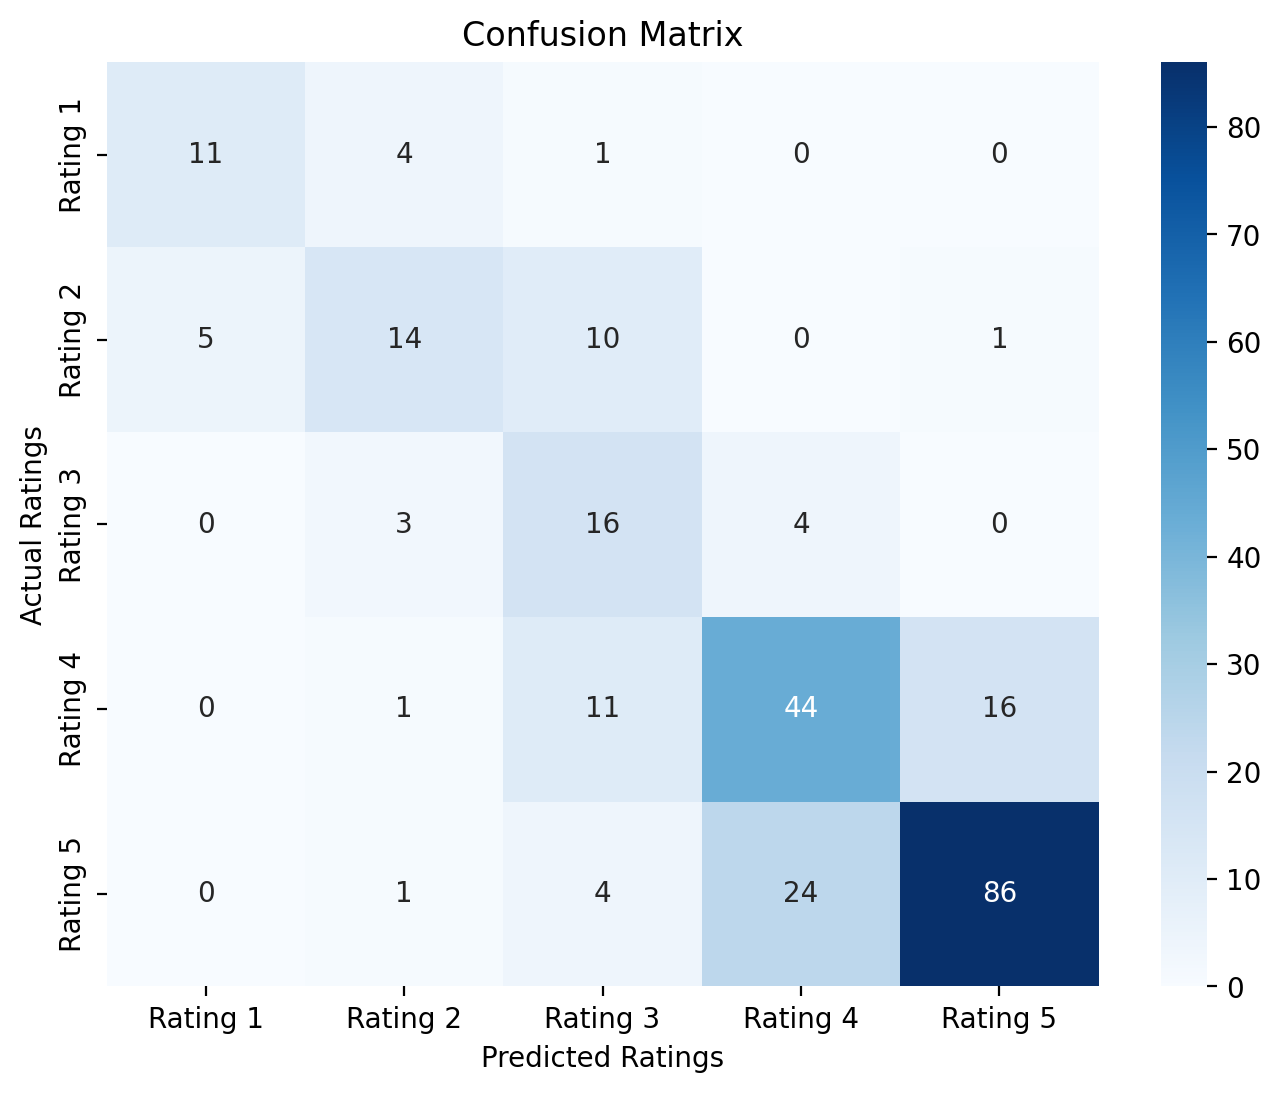

In [40]:
# create confusion matrix
# YOUR CODE HERE
print(confusion_matrix(actual_labels, predicted_labels))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(actual_labels, predicted_labels), annot=True, fmt='d', cmap='Blues', xticklabels=['Rating 1', 'Rating 2', 'Rating 3', 'Rating 4', 'Rating 5'], yticklabels=['Rating 1', 'Rating 2', 'Rating 3', 'Rating 4', 'Rating 5'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()


the validation set was split in half to make a test set.
-------------------Evaluation on Epoch 4 ------------------
The BERT-based classifier achieved an overall moderate accuracy of 66.8% on the test set.

The classification report reveals the following insights:
1. Rating 5 had the best performance, with precision of 0.83, recall of 0.75, and an F1-score of 0.79.
2. Rating 3 was the most challenging category, achieving the lowest precision 0.38 despite a recall of 0.70, indicating the model frequently misclassified other ratings as Rating 3.
3. Macro Average (0.62 F1-score) indicates the model struggles with balance across all categories, especially with mid-range ratings.
4. The weighted average F1-score of 0.70 suggests the model performs relatively well when considering class distribution.


The confusion matrix provides the following insights:
1. Rating 5 is the most correctly classified class, with 86 true positives out of 115 instances.
2. Rating 3 shows significant misclassification, as most of its instances were predicted as Rating 4 or Rating 5.

The overall results suggest a strong possibility of overfitting, where the traininig loss consistenly decreased across epoches, while the validation loss start to increase.

Naive Bayes Classifier has lower performance for tasks involving semantic understanding in general, as it assumes feature independence without contextual understanding.

On the other hand, BERT uses pre-trained embeddings to get a fine grasp on relationships between words, outperforming Naive Bayes classifier on metrics such as accuracy and F1 score.

Neverthelss, BERT's susceptibility to overfitting emphasises the need for larger datasets and careful hyperparameter tuning.

Suggestions on improvement:
1. the model struggles to classify rating 3 and 4. Increase representation for these two classes can improve model performance.
2. make the dataset more balanced.
3. Adopt techniques such as dropout or early stopping to mitigate overfitting.


--------------- Evaluation on Epoch 2 ---------------------

The model achieved an accuracy of 64.8%, indicating a moderate ability to correctly classify ratings.

The weighted average precision (0.65), recall (0.65), and F1-score (0.64) indicate the model performs reasonably well across the dataset, but struggles with ambiguous cases.

Classification report insight:
1. Class 5 performed the best with a precision of 0.76 and recall of 0.80. The model correctly identifies most of the instances of Rating 5, likely due to stronger patterns in the text for this rating.
2. For class 3, the precision is relatively low (0.45), but recall is higher (0.62), indicating the model frequently predicts other ratings as Rating 3.
3. For class 1, precision is high (0.75), but recall drops to 0.50, meaning that while the model is confident when predicting Rating 1, it misses many instances of Rating 1.
4. As for rating 2 and 4, the model performs roughly the same as the previous overfitting version, reflecting challenges in disinguishing mid-range ratings.

Overall, even though the performance at epoch 2 is slightly lower in terms of accuracy, the weighted F1-score of 0.64 shows a balanced performance with reduced overfitting compare to epoch4.  
